In [2]:
import numpy as np
from numpy import ndarray

from scipy import ndimage
from scipy import misc
from scipy import fftpack

import cv2 as cv

from skimage import color

import matplotlib.pyplot as plt


%matplotlib inline

ImportError: dlopen(/Users/Rydub/anaconda3/lib/python3.4/site-packages/cv2/cv2.so, 2): Symbol not found: _clock_gettime
  Referenced from: /Users/Rydub/anaconda3/lib/python3.4/site-packages/cv2/.dylibs/libavutil.55.78.100.dylib (which was built for Mac OS X 10.12)
  Expected in: /usr/lib/libSystem.B.dylib
 in /Users/Rydub/anaconda3/lib/python3.4/site-packages/cv2/.dylibs/libavutil.55.78.100.dylib

In [390]:
quant_DCT= np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                     [12, 12, 14, 19, 26, 58, 60, 55],
                     [14, 13, 16, 24, 40, 57, 69, 56],
                     [14, 17, 22, 29, 51, 87, 80, 62],
                     [18, 22, 37, 56, 68,109,103, 77],
                     [24, 35, 55, 64, 81,104,113, 92],
                     [49, 64, 78, 87,103,121,120,101],
                     [72, 92, 95, 98,112,100,103, 99]])

In [732]:
def rgb2YCbCr(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    Y = 0.299*R + 0.587*G + 0.114*B
    Cb = 128*np.ones(R.shape) - 0.168736*R - 0.331264*G + 0.5*B
    Cr = 128*np.ones(R.shape) + 0.5*R -0.418688*G - 0.081312*B
    channels = [Y, Cb, Cr]
    img_YCbCr = np.stack(channels, axis = 2)
    return img_YCbCr

In [733]:
def YCbCr2rgb(img):
    Y = img[:,:,0]
    Cb = img[:,:,1]
    Cr = img[:,:,2]
    R = Y + 1.402*(Cr-128)
    G = Y - 0.344136*(Cb - 128*np.ones(Cb.shape)) - 0.714136*(Cr - 128*np.ones(Cr.shape))
    B = Y + 1.772*(Cb-128*np.ones(Cb.shape))
    channels = [R, G, B]
    img_RGB = np.stack(channels, axis = 2)
    return img_RGB

In [605]:
def EE123_psnr(ref, meas, maxVal=255):
    assert np.shape(ref) == np.shape(meas), "Test image must match measured image dimensions"
        
    
    dif = (ref.astype(float)-meas.astype(float)).ravel()
    mse = np.linalg.norm(dif)**2/np.prod(np.shape(ref))
    psnr = 10*np.log10(maxVal**2.0/mse)
    return psnr

In [794]:
# def down_samp(img, dim_0_n=1, dim_1_n=1, interp = cv.INTER_AREA):
#     curr_shape = img.shape
#     new_shape_col_maj = (curr_shape[1]//dim_1_n, curr_shape[0]//dim_0_n)
#     down_samp_img = cv.resize(img, new_shape_col_maj)
#     return down_samp_img
def down_samp(img, dim_0_n=1, dim_1_n=1):
    return img[::dim_0_n, ::dim_1_n]

In [795]:
def up_samp(img, shape, interp = cv.INTER_CUBIC):
    col_maj_shape = (shape[1], shape[0])
    up_samp_img = cv.resize(img, col_maj_shape)
    return up_samp_img

In [705]:
def adjust_quant_mat(Q = 50):
    if Q == 50:
        return quant_DCT
    elif (Q < 50):
        S = 5000/Q
    else:
        S = 200 - 2*Q
    adjust_quant_mat = np.floor((S*quant_DCT + 50*np.ones(quant_DCT.shape))/100)
    return adjust_quant_mat

In [895]:
def quantize_jpeg_dct(channels, Q=50):
    # Channels must be a multiple of 8 in each dim
    quant_block = adjust_quant_mat(Q)
    for i in range(len(channels)):
        dim_0, dim_1 = channels[i].shape
        assert dim_0 % 8 == 0 and dim_1 % 8 == 0
        num_reps_0 = dim_0//8
        num_reps_1 = dim_1//8
        quant_mat = np.tile(quant_block, (num_reps_0, num_reps_1))
        channels[i] = np.divide(channels[i], quant_mat)
        channels[i] = np.around(channels[i])
        channels[i].astype(dtype=np.uint8)
    return channels

In [896]:
def dequantize_jpeg_dct(channels, Q=50):
    quant_block = adjust_quant_mat(Q)
    for i in range(len(channels)):
        dim_0, dim_1 = channels[i].shape
        assert dim_0 % 8 == 0 and dim_1 % 8 == 0
        num_reps_0 = dim_0//8
        num_reps_1 = dim_1//8
        quant_mat = np.tile(quant_block, (num_reps_0, num_reps_1))
        channels[i] = np.multiply(channels[i], quant_mat)   
    return channels

In [897]:
def jpeg_comp_dct(img, Q=50, ds_chroma_0 = 2, ds_chroma_1 = 1):
    #convert to YCbCr
    img_shape = img.shape
    img_ycbcr = rgb2YCbCr(img)
    channels = [img_ycbcr[:,:,0], down_samp(img_ycbcr[:,:,1], ds_chroma_0, ds_chroma_1), down_samp(img_ycbcr[:,:,2], ds_chroma_0, ds_chroma_1)]
    for i in range(len(channels)):
        curr_shape = channels[i].shape
        rem_dim_0 = curr_shape[0] % 8
        rem_dim_1 = curr_shape[1] % 8
        if rem_dim_0 != 0:
            num_new_rows = 8 - rem_dim_0
            new_rows = np.tile(channels[i][-1,:], (num_new_rows, 1))
            channels[i] = np.concatenate([channels[i], new_rows], 0)
        if rem_dim_1 != 0:
            num_new_cols = 8 - rem_dim_1
            new_cols = np.tile(np.reshape(channels[i][:,-1],(channels[i].shape[0],1)), (1, num_new_cols))
            channels[i] = np.concatenate([channels[i], new_cols], 1)  
    #perform DCT on 8x8 blocks
    for chn_ind in range(len(channels)):
        curr_channel = channels[chn_ind]
        for i in range(0, curr_channel.shape[0], 8):
            for j in range(0, curr_channel.shape[1], 8):
                curr_channel[i:i+8,j:j+8] = fftpack.dct(fftpack.dct(curr_channel[i:i+8,j:j+8], axis=0, norm='ortho'), axis=1, norm='ortho')
    #clip image to prevent integer rollover
    #Quantize dct components
    channels = quantize_jpeg_dct(channels, Q=Q)
    for chn_ind in range(len(channels)):
        channels[chn_ind] = np.clip(channels[chn_ind], 0, 255)   
    
    return channels
    

In [898]:
def jpeg_decomp_dct(channels, img_shape, Q=50, ds_chroma_0 = 2, ds_chroma_1 = 1):
    #reverse quantization
    channels = dequantize_jpeg_dct(channels, Q=Q)
    for chn_ind in range(len(channels)):
        curr_channel = channels[chn_ind]
        for i in range(0, curr_channel.shape[0], 8):
            for j in range(0, curr_channel.shape[1], 8):
                curr_channel[i:i+8,j:j+8] = fftpack.idct(fftpack.idct(curr_channel[i:i+8,j:j+8], axis=0, norm='ortho'), axis=1, norm='ortho')    
    for chn_ind in range(len(channels)):
        #For the lumanince channel we need the original img_shape
        if chn_ind == 0:
            channels[chn_ind] = channels[chn_ind][:img_shape[0],:img_shape[1]]
        #otherwise we need to take how many downsampled samples we had
        else:
            dim_0_samps = img_shape[0]//ds_chroma_0
            dim_1_samps = img_shape[1]//ds_chroma_1
            channels[chn_ind] = channels[chn_ind][:dim_0_samps,:dim_1_samps]            
            
    # interpolate chroma channels back to original size
    for chn_ind in range(1,len(channels)):      
        channels[chn_ind] = up_samp(channels[chn_ind], (img_shape[0], img_shape[1]))
    ycbcr_img = np.stack(channels, axis = 2)
    rgb_img = YCbCr2rgb(ycbcr_img)
    rgb_img = np.around(rgb_img)
    rgb_img = rgb_img.astype(np.uint8)
    return rgb_img

    

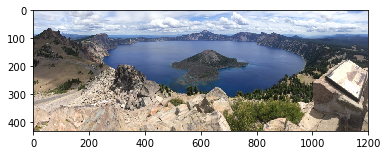

In [899]:
test_im_f_name = 'createrLake.tiff'
test_img = scipy.ndimage.imread(test_im_f_name)
plt.figure()
plt.imshow(test_img)

In [903]:
def channels_to_bytes(channels):
    byte_list = []
    shapes = []
    for channel in channels:
        curr_shape = channel.shape
        shapes.append(curr_shape)
        flattened_channel = np.reshape(channel, (curr_shape[0]*curr_shape[1]))
        curr_bytes = flattened_channel.tobytes()
        byte_list.append(curr_bytes)
    all_bytes = b''.join(byte_list)
    return (all_bytes, shapes)

In [904]:
def bytes_to_channels(bytes_str, shapes):
    flattend_channels = np.frombuffer(bytes_str, dtype = np.uint8)
    channels = []
    chn_idx = 0
    for shape in shapes:
        chn_end = chn_idx + shape[0]*shape[1]
        flat_chn = flattend_channels[chn_idx:chn_end]
        channel = np.reshape(flat_chn, shape)
        channels.append(channel)
        chn_idx = chn_end
    return channels

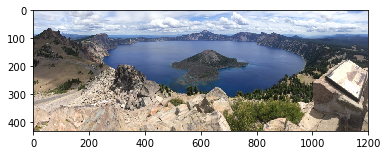

In [905]:
test_im_f_name = 'createrLake.tiff'
test_img = scipy.ndimage.imread(test_im_f_name)
plt.figure()
plt.imshow(test_img)

In [906]:
channels_jpeg = jpeg_comp_dct(test_img, Q=80, ds_chroma_0 = 4, ds_chroma_1 = 2)

In [907]:
rec_img = jpeg_decomp_dct(channels_jpeg, test_img.shape, Q=80, ds_chroma_0 = 4, ds_chroma_1 = 2)

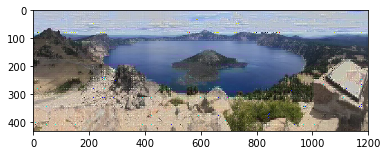

In [908]:
plt.figure()
plt.imshow(rec_img)

In [909]:
EE123_psnr(test_img, rec_img)

21.33104476138014

Testing bytes to channesl and back

In [1]:
byte_str, shapes = channels_to_bytes('createrlake.tiff')

NameError: name 'test_img' is not defined

In [835]:
rec_channels = bytes_to_channels(byte_str, shapes)


In [836]:
rec_img = np.stack(rec_channels, axis=2)

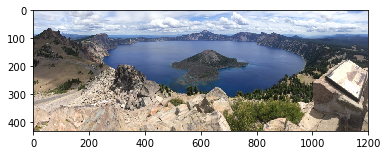

In [837]:
plt.figure()
plt.imshow(rec_img)

In [880]:
def jepeg_back_forth(img, Q=90, ds_chroma_0 = 2, ds_chroma_1 = 1):
    #forward
    img_shape = img.shape
    img_ycbcr = rgb2YCbCr(img)
    channels = [img_ycbcr[:,:,0], down_samp(img_ycbcr[:,:,1], ds_chroma_0, ds_chroma_1), down_samp(img_ycbcr[:,:,2], ds_chroma_0, ds_chroma_1)]
    for i in range(len(channels)):
        curr_shape = channels[i].shape
        rem_dim_0 = curr_shape[0] % 8
        rem_dim_1 = curr_shape[1] % 8
        if rem_dim_0 != 0:
            num_new_rows = 8 - rem_dim_0
            new_rows = np.tile(channels[i][-1,:], (num_new_rows, 1))
            channels[i] = np.concatenate([channels[i], new_rows], 0)
        if rem_dim_1 != 0:
            num_new_cols = 8 - rem_dim_1
            new_cols = np.tile(np.reshape(channels[i][:,-1],(channels[i].shape[0],1)), (1, num_new_cols))
            channels[i] = np.concatenate([channels[i], new_cols], 1)
    #center coefficients   
    
    #perform DCT on 8x8 blocks
    for chn_ind in range(len(channels)):
        curr_channel = channels[chn_ind]
        for i in range(0, curr_channel.shape[0], 8):
            for j in range(0, curr_channel.shape[1], 8):
                curr_channel[i:i+8,j:j+8] = fftpack.dct(fftpack.dct(curr_channel[i:i+8,j:j+8], axis=0, norm='ortho'), axis=1, norm='ortho')
    #clip image to prevent integer rollover
    #Quantize dct components
    channels = quantize_jpeg_dct(channels, Q=Q)
    for chn_ind in range(len(channels)):
        channels[chn_ind] = np.clip(channels[chn_ind], 0, 255)   
#     #backwards
    channels = dequantize_jpeg_dct(channels, Q=Q)
    for chn_ind in range(len(channels)):
        curr_channel = channels[chn_ind]
        for i in range(0, curr_channel.shape[0], 8):
            for j in range(0, curr_channel.shape[1], 8):
                curr_channel[i:i+8,j:j+8] = fftpack.idct(fftpack.idct(curr_channel[i:i+8,j:j+8], axis=0, norm='ortho'), axis=1, norm='ortho')    
    for chn_ind in range(len(channels)):
        #For the lumanince channel we need the original img_shape
        if chn_ind == 0:
            channels[chn_ind] = channels[chn_ind][:img_shape[0],:img_shape[1]]
        #otherwise we need to take how many downsampled samples we had
        else:
            dim_0_samps = img_shape[0]//ds_chroma_0
            dim_1_samps = img_shape[1]//ds_chroma_1
            channels[chn_ind] = channels[chn_ind][:dim_0_samps,:dim_1_samps]            
            
    # interpolate chroma channels back to original size
    for chn_ind in range(1,len(channels)):      
        channels[chn_ind] = up_samp(channels[chn_ind], (img_shape[0], img_shape[1]))
    ycbcr_img = np.stack(channels, axis = 2)
    rgb_img = YCbCr2rgb(ycbcr_img)
    rgb_img = np.around(rgb_img)
    rgb_img = rgb_img.astype(np.uint8)
    return rgb_img

In [881]:
new_img = jepeg_back_forth(test_img, 80, 4, 4)

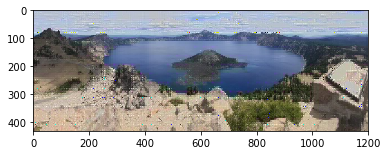

In [882]:
plt.figure()
plt.imshow(new_img)

In [876]:
EE123_psnr(test_img, new_img)

21.319808431463333

In [773]:
jpeg_channels = jpeg_comp_dct(test_img)